Australian Political Party Donations
===

__Overview__

Some individuals and companies donate a lot of money to Australian political parties. This sheet summarises these donations.

__Source of Data__

All the data in this Notebook comes from the Australian Electoral Commission website. You can do your own research by looking [here](http://periodicdisclosures.aec.gov.au/).


In [227]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import display, HTML
import urllib
import itertools as itt
from ipywidgets import *
import json
pd.options.display.float_format = '${:,.0f}'.format
pd.set_option('max_colwidth', 1000, 'max_rows', 100)
%matplotlib inline

__Load configurations__

In [228]:
with open('year_info.json', 'r') as f:
    yearly_info = json.load(f)
with open('parties.json', 'r') as f:
    parties = json.load(f)

__Before evaluating the rest of this notebook, select the year that you would like to analyse__

In [229]:
class y:
    def __init__(self, year):
        self.year = year
    def set_year(self, year):
        self.year = year
yr = y('2014-2015')

w_risk_style = widgets.Dropdown(
    description = 'Year',
    options=list(sorted(yearly_info.keys(), reverse=True))
)
w_risk_style.observe(lambda b: yr.set_year(w_risk_style.value))
display(w_risk_style)

__Data Loading__

Load data from the csvs downloaded off the AEC website.

In [230]:
donations = {}
for party in yearly_info[str(yr.year)]['major_parties']:
    party_display = [p for p in parties if p['file'] == party][0]['display']
    p_dons = pd.read_csv('data/{:s}-{:s}.csv'.format(party, yr.year))
    donations[party_display] = p_dons
colors = dict([(p['display'], p['color']) for p in parties])

__Donation Totals__

Total value of donations over the reportable ($12,800) threadhold in 2014-2015:



,Total Donated
National,"$680,413"
Palmer United,"$9,820,615"
Greens,"$220,116"
Labor,"$4,174,712"
Liberal,"$7,893,118"


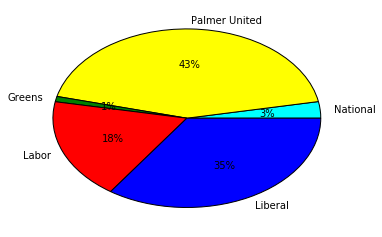

In [231]:
print('Total value of donations over the reportable (${:,d}) threadhold in {:s}:'.format(
        yearly_info[yr.year]['reportable_threshold'], 
        yr.year))
print('')
totals = list(map(lambda v: v['AmountPaid'].sum(), donations.values()))
display(pd.DataFrame(totals, donations.keys(), columns=['Total Donated']))    
ax = plt.pie(totals, 
             labels=list(donations.keys()), 
             colors=[colors[p] for p in donations.keys()],
             autopct='%.0f%%')

__Distribution of Donation Sizes__

This helps us get an idea about the size of donations to each party. 

There were 30 reportable donations to the National party. The average donation size was $23K.
There were 5 reportable donations to the Palmer United party. The average donation size was $1,964K.
There were 10 reportable donations to the Greens party. The average donation size was $22K.
There were 103 reportable donations to the Labor party. The average donation size was $41K.
There were 161 reportable donations to the Liberal party. The average donation size was $49K.
The largest donation was to the Palmer United party for $5,991K.


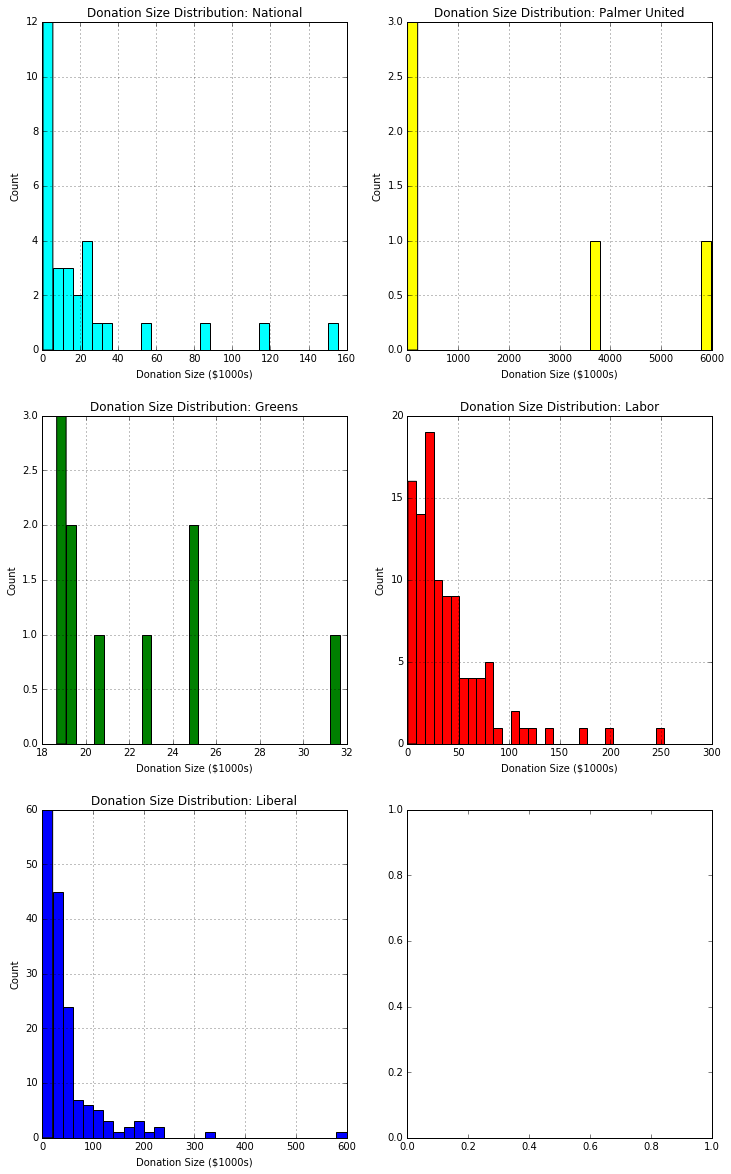

In [232]:
num_majors = len(yearly_info[str(yr.year)]['major_parties'])
f, axarr = plt.subplots(int(num_majors / 2) + num_majors % 2, 2)
i = 0
max_don = 0
max_pty = ''
for party, dons in donations.items():
    ax = axarr[int(i / 2), i % 2]
    grouped_dons = dons.groupby('DonorClientNm').sum()['AmountPaid'] / 1000
    ax = (grouped_dons).hist(bins=30, ax = ax, color=colors[party])
    mx = max(grouped_dons)
    if mx > max_don:
        max_don = mx
        max_pty = party        
    ax.set_xlabel('Donation Size ($1000s)')
    ax.set_ylabel('Count')
    ax.set_title('Donation Size Distribution: %s' % party)
    avg = sum(grouped_dons) / len(grouped_dons)
    num = len(grouped_dons)
    print('There were {:d} reportable donations to the {:s} party. '.format(num, party) +
          'The average donation size was ${:,.0f}K.'.format(avg))   
    i += 1
fig = plt.gcf().set_size_inches(12, 20)
print('The largest donation was to the {:s} party for ${:,.0f}K.'.format(max_pty, max_don))

__Cumulative Distributions of Donations__

This also helps us understand the size of donations that each party recieved. We additionally add some lines to these charts to help show what 50% of the donations represents, and how many donors make up 50% of the total value of donations.

It's also worth noting that the more *curved* this chart is, the more *unequal* the size of the donations are. If everyone donated the same amount we would expect the green line to be half way along the chart and for the blue line to be a straight line. What this shows is that for some political parties a reasonably small percentage of donors account for 50% of the total value of donations. Further down this sheet, we'll dig into who these donors are.

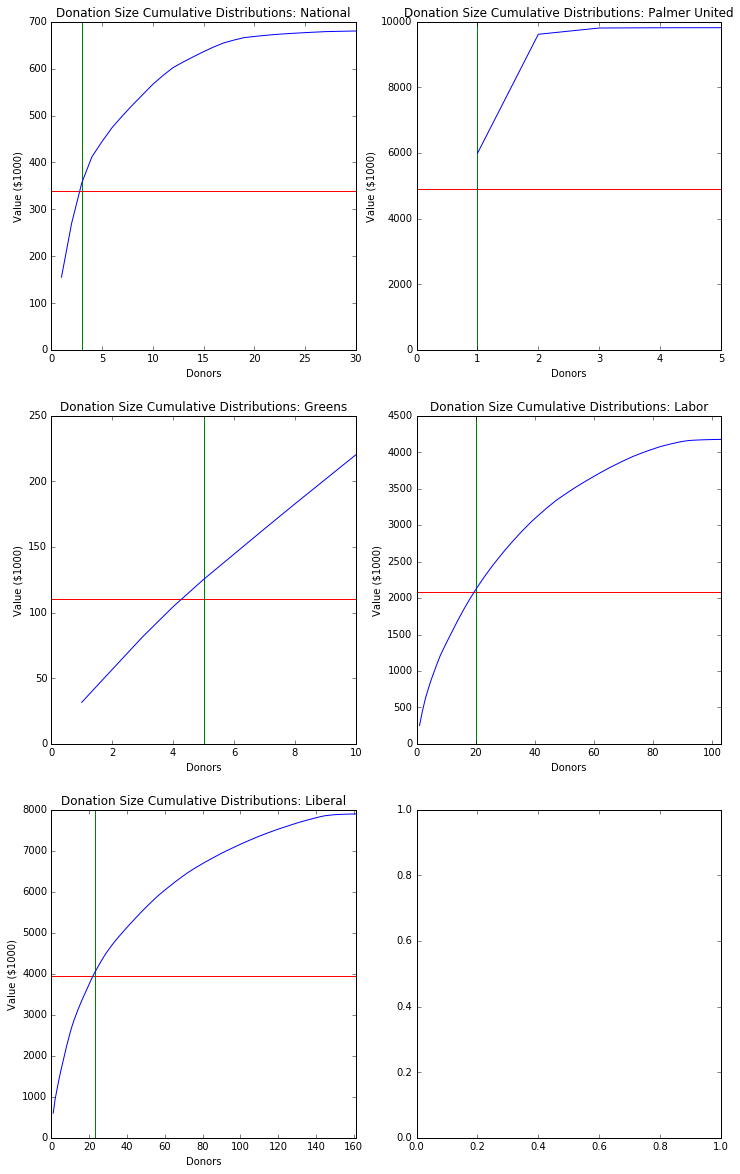

In [233]:
num_majors = len(yearly_info[str(yr.year)]['major_parties'])
f, axarr = plt.subplots(int(num_majors / 2) + num_majors % 2, 2)
i = 0
for party, dons in donations.items():
    ax = axarr[int(i / 2), i % 2]
    sums = dons.groupby('DonorClientNm').sum()['AmountPaid']
    sums = sums.sort_values(ascending=False) / 1000
    sums.index = range(1, len(sums) + 1)
    cumsums = sums.cumsum()
    total = sums.sum()
    half = total / 2
    first_half = cumsums[cumsums < half]
    half_idx = 0
    if len(first_half.index) > 0:
        half_idx = first_half.index[-1]
    ax.axhline(half, color='r')
    ax.axvline(half_idx + 1, color='g')
    cumsums.plot(ax=ax)
    ax.set_title('Donation Size Cumulative Distributions: %s' % party)
    ax.set_xlabel('Donors')
    ax.set_ylabel('Value ($1000)')
    ax.set_ylim(0, ax.get_ylim()[1])
    i += 1
fig = plt.gcf().set_size_inches(12, 20) 

__Big Donors__

We'd like to have a look at who are the biggest donors to each of the parties. For this we'll look the largest donors who cumulatively account for 50% of the total value of donations to each party.

In [234]:
def gurl(n):
    data = {'q' : n}
    url = 'https://www.google.com/search?%s' % urllib.parse.urlencode(data)
    return url
    
for party, dons in donations.items():
    sums = dons.groupby('DonorClientNm').sum()
    sums = pd.DataFrame(sums.sort_values(by='AmountPaid', ascending=False)['AmountPaid'])
    sums['cumsum'] = sums.cumsum()
    sums = sums.reset_index()
    total = sums['AmountPaid'].sum()
    sums = sums[(sums['cumsum'] < total / 2) | (sums.index == 0)]
    del sums['cumsum']
    sums = sums.set_index('DonorClientNm')
    sums = sums.reset_index()
    sums['Google Search'] = sums.apply(lambda r: '<a href=\"%s\">Search</a>' % gurl(r['DonorClientNm']), axis=1)
    display(HTML('<h2> %s </h2>' % party))
    display(HTML(sums.to_html(escape=False)))

__Multiple Donations__

Some donors donate to multiple political parties. Here's a lists of these donors.

In [235]:
donors = {}
for party, dons in donations.items():
    donors[party] = set(dons['DonorClientNm'])
multi_donors = set()
for comb in itt.product(donors.keys(),donors.keys()):
    if comb[0] != comb[1]:
        multi_donors = multi_donors.union(donors[comb[0]].intersection(donors[comb[1]]))    

In [236]:
table = []
for donor in multi_donors:
    row = {'Donor' : donor}
    for party, dons in donations.items():
        row[party] = dons[dons['DonorClientNm'] == donor]['AmountPaid'].sum()
    table.append(row)
multi_donor_df = pd.DataFrame(table)
multi_donor_df['Google Search'] = multi_donor_df.apply(
    lambda r: '<a href=\"%s\">Search</a>' % gurl(r['Donor']), axis=1)


display(HTML(multi_donor_df.to_html(escape=False)))

__Largest Recipients__

In instances where a donor donated to multiple political parties, which parties got the most money? We look at this in two ways; the sum of all donations to a party from a multi-donor, and the number of instances where a party was the largest recipient. These two measures while similar, are slightly different and the latter is less suseptible to influence from a small number of large donors.


In [237]:
def largest_recipient(row):
    mx = max([k for k in row if type(k) is float])
    largest = ''
    largest_key = [key for key, value in row.items() if value == mx][0]
    return largest_key

multi_donor_df['Largest'] = multi_donor_df.apply(largest_recipient, axis=1)
largest_recipients = {}
for party in donations.keys():
    largest_recipients[party] = len(multi_donor_df[multi_donor_df['Largest'] == party])
largest_recipients = pd.DataFrame(list(largest_recipients.values()), 
                                  list(largest_recipients.keys()), 
                                  columns=['Instances where the party was the largest recipient'])
multi_party_sums = pd.DataFrame(multi_donor_df[list(donations.keys())].sum(), 
                                columns=['Total donated from donors to multiple parties'])    

,Total donated from donors to multiple parties
National,"$492,285"
Palmer United,$0
Greens,$0
Labor,"$2,640,040"
Liberal,"$3,670,729"


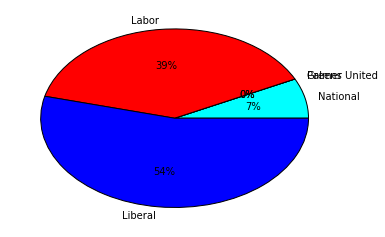

In [238]:
display(multi_party_sums)
ax = plt.pie(multi_party_sums.values, 
        labels=multi_party_sums.index.values,
        colors=[colors[p] for p in multi_party_sums.index.values],
        autopct='%.f%%')

,Instances where the party was the largest recipient
Liberal,45
Palmer United,0
Labor,26
Greens,0
National,5


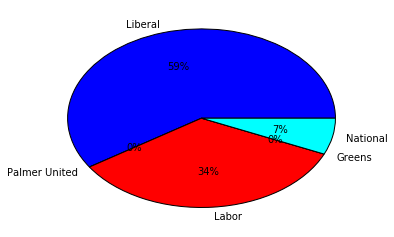

In [239]:
display(largest_recipients)
ax = plt.pie(largest_recipients.values,
             labels=largest_recipients.index.values,
             colors=[colors[p] for p in largest_recipients.index.values],
             autopct='%.f%%')